# Sieci kapsułowe (CapsNets)

Na podstawie artykułu [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829) autorstwa Sary Sabour, Nicholasa Frossta i Geoffrey`a E. Hintona (NIPS 2017).

Częściową inspirację stanowi implementacja [CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow), której twórcą jest Huadong Liao.

# Wprowadzenie

[Film ten](https://youtu.be/pPN8d0E3900) wyjaśnia kluczowe koncepcje związane z sieciami kapsułowymi:

In [0]:
from IPython.display import HTML
HTML("""<iframe width="560" height="315" src="https://www.youtube.com/embed/pPN8d0E3900" frameborder="0" allowfullscreen></iframe>""")

Możesz chcieć także obejrzeć [ten film](https://youtu.be/2Kawrd5szHE), w którym zaprezentowano główne trudności związane z tą techniką:

In [0]:
HTML("""<iframe width="560" height="315" src="https://www.youtube.com/embed/2Kawrd5szHE" frameborder="0" allowfullscreen></iframe>""")

# Importowane moduły

Do tworzenia ładnych rysunków:

In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Będziemy potrzebować modułów NumPy i TensorFlow:

In [2]:
import numpy as np
import tensorflow as tf

# Odtwarzalność

Zresetujmy domyślny graf na wypadek, gdybyś ponownie uruchamiał ten notatnik bez ponownego uruchamiania jądra:

In [0]:
tf.reset_default_graph()

Wyznaczmy ziarna losowości, dzięki czemu będziemy zawsze uzyskiwać te same rezultaty:

In [0]:
np.random.seed(42)
tf.set_random_seed(42)

# Wczytywanie zestawu danych MNIST

Tak, wiem, znowu zestaw MNIST. Najprawdopodobniej jednak ten potężny model będzie również przetwarzał większe zestawy dany. Czas pokaże.

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Spójrzmy, jak wyglądają te odręcznie pisane cyfry:

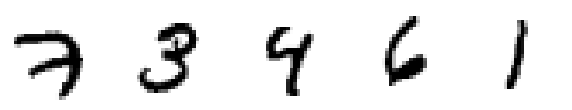

In [6]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = mnist.train.images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

A to są ich etykiety:

In [7]:
mnist.train.labels[:n_samples]

array([7, 3, 4, 6, 1], dtype=uint8)

Stwórzmy teraz sieć kapsułową służącą do klasyfikowania tych obrazów. Poniżej prezentuję jej ogólną architekturę. Miłego podziwiania sztuki ASCII! ;-)
Uwaga: dla zwiększenia czytelności pominąłem dwie strzałki: od etykiet do maski oraz od obrazów wejściowych do funkcji straty rekonstrukcji.

```
                              F. straty
                                  ↑
                        ┌─────────┴────────────────┐
      Etykiety → F. straty marginesu    F. straty rekonstrukcji
                        ↑                          ↑
                     Długość                    Dekoder
                        ↑                          ↑ 
                  Kapsuły cyfr ───────Maska────────┘
                   ↖↑↗ ↖↑↗ ↖↑↗
                 Kapsuły główne
                        ↑      
                Obrazy wejściowe
```

Będziemy tworzyć graf począwszy od dołu i stopniowo będziemy "szli" do góry (najpierw lewej strony). Do dzieła!

# Obrazy wejściowe

Rozpocznijmy od umieszczenia węzła zastępczego dla obrazów wejściowych (28×28 pikseli, 1 kanał kolorów = czarno-biały).

In [0]:
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name="X")

# Kapsuły główne

Pierwsza warstwa będzie składała się z 32 map zawierających po 6×6 kapsuł, natomiast każda kapsuła będzie generowała ośmiowymiarowy wektor aktywacji:

In [0]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 kapsuł głównych
caps1_n_dims = 8

Do obliczenia ich wyników będziemy potrzebować dwóch standardowych warstw splotowych:

In [0]:
conv1_params = {
    "filters": 256,
    "kernel_size": 9,
    "strides": 1,
    "padding": "valid",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": caps1_n_maps * caps1_n_dims, # 256 filtrów splotowych
    "kernel_size": 9,
    "strides": 2,
    "padding": "valid",
    "activation": tf.nn.relu
}

In [11]:
conv1 = tf.layers.conv2d(X, name="splot1", **conv1_params)
conv2 = tf.layers.conv2d(conv1, name="splot2", **conv2_params)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Uwaga: użyliśmy tu jądra o rozmiarze 9 i nie wprowadziliśmy uzupełniania zerami (z jakiegoś powodu to oznacza typ `"valid"` uzupełniania zerami), zatem obraz po każdej warstwie splotowej zostanie zmniejszony o 9-1=8 pikseli (z 28×28 do 20×20, a następnie z 20×20 do 12×12), a ponieważ użyliśmy kroku o wartości 2 w drugiej warstwie splotowej, rozmiar obrazu został zmniejszony o połowę. W ten właśnie sposób otrzymaliśmy mapy cech 6×6.

Następnie tak przekształcimy wynik, aby uzyskać zbiór ośmiowymiarowych wektorów, reprezentujących rezultaty kapsuł głównych. Wynik warstwy `splot2` to tablica zawierająca 32×8=256 map cech dla każdego przykładu, gdzie rozmiar każdej mapy cech wynosi 6×6. Zatem wymiary sygnału wyjściowego to (_rozmiar grupy_, 6, 6, 256). Chcemy podzielić tę wartość 256 na 32 ośmiowymiarowe wektory. Moglibyśmy tego dokonać poprzez przekształcenie wymiarów w postać (_rozmiar grupy_, 6, 6, 32, 8). Jednak ta pierwsza warstwa kapsułowa będzie w pełni połączona z następną warstwą kapsułową, dlatego wystarczy spłaszczyć siatki 6×6. Oznacza to, że możemy przekształcić wymiary następująco: (_rozmiar grupy_, 6×6×32, 8).

In [0]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims],
                       name="kaps1_nieprzetw")

Musimy teraz "zgnieść" te wektory. Zdefiniujmy funkcję `squash()` na podstawie równania (1) z artykułu:

$\operatorname{squash}(\mathbf{s}) = \dfrac{\|\mathbf{s}\|^2}{1 + \|\mathbf{s}\|^2} \dfrac{\mathbf{s}}{\|\mathbf{s}\|}$

Funkcja `squash()` "zgniecie" wszystkie wektory w wyznaczonej tablicy wzdłuż określonej (domyślnie ostatniej) osi.

**Ostrzeżenie**: czycha tu na Ciebie paskudna pułapka - pochodna z $\|\mathbf{s}\|$ pozostaje niezdefiniowana, gdy $\|\mathbf{s}\|=0$, zatem nie możemy tu użyć funkcji `tf.norm()`, gdyż w fazie uczenia czeka nas przykra niespodzianka: jeżeli wektor jest zerowy, gradienty będą miały wartość `nan`, zatem w czasie aktualizowania zmiennych przez optymalizator, zmienne te również staną się `nan` i z tego powodu utkniesz w krainie `nan`. Rozwiązaniem jest ręczna implementacja normy poprzez obliczenie pierwiastka kwadratowego z sumy kwadratów i dodatnie małej wartości epsilon: $\|\mathbf{s}\| \approx \sqrt{\sum\limits_i{{s_i}^2}\,\,+ \epsilon}$.

In [0]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name="squash"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

Uzyskajmy teraz za pomocą tej funkcji wynik $\mathbf{u}_i$ dla każdej kapsuły głównej $i$ :

In [14]:
caps1_output = squash(caps1_raw, name="kaps1_wyjscie")

Instructions for updating:
keep_dims is deprecated, use keepdims instead


Świetnie! Uzyskaliśmy wynik pierwszej warstwy kapsułowej. Nie było zbyt trudno, prawda? Jednak dopiero teraz zaczyna się zabawa.

# Kapsuły cyfr

W celu obliczenia wyniku kapsuł cyfr, musimy najpierw obliczyć wektory przewidywanego wyniku (po jednym na każdą parę kapsuła główna/cyfr). Następnie będziemy mogli przeprowadzić trasowanie za pomocą algorytmu zgody.

## Obliczanie wektorów przewidywanego wyniku

Warstwa kapsuł cyfr zawiera 10 szesnastowymiarowych kapsuł (po jednej na każdą cyfrę):

In [0]:
caps2_n_caps = 10
caps2_n_dims = 16

Chcemy dla każdej kapsuły $i$ w pierwszej warstwie przewidzieć wynik każdej kapsuły $j$ w drugiej warstwie. W tym celu potrzebna nam będzie macierz transformacji $\mathbf{W}_{i,j}$ (po jednej na każdą parę kapsuł ($i$, $j$)), po czym będziemy mogli obliczyć prognozowany wynik $\hat{\mathbf{u}}_{j|i} = \mathbf{W}_{i,j} \, \mathbf{u}_i$ (równanie (2) po prawej w artykule). Chcemy przekształcić wektor ośmiowymiary w wektor szesnastowymiarowy, dlatego każda macierz transformacji $\mathbf{W}_{i,j}$ musi mieć wymiary (16, 8).

Aby obliczyć $\hat{\mathbf{u}}_{j|i}$ dla każdej pary kapsuł ($i$, $j$), wykorzystamy przydatną własność funkcji `tf.matmul()`: prawdopodobnie wiesz, że pozwala ona mnożyć dwie macierze, ale być może nie masz pojęcia, że umożliwia ona również mnożenie tablic o większej liczbie wymiarów. Traktuje ona tablice jak tablice macierzy i przeprowadza iloczyn macierzowy po elementach. Załóżmy, na przykład, że dysponujemy dwiema czterowymiarowymi tablicami, z których każda zawiera siatkę 2x3 macierzy. Pierwsza tablica zawiera macierze $\mathbf{A}, \mathbf{B}, \mathbf{C}, \mathbf{D}, \mathbf{E}, \mathbf{F}$, a druga - $\mathbf{G}, \mathbf{H}, \mathbf{I}, \mathbf{J}, \mathbf{K}, \mathbf{L}$. Jeżeli pomnożysz obydwie tablice czterowymiarowe za pomocą funkcji `tf.matmul()`, otrzymasz następujący rezultat:

$
\pmatrix{
\mathbf{A} & \mathbf{B} & \mathbf{C} \\
\mathbf{D} & \mathbf{E} & \mathbf{F}
} \times
\pmatrix{
\mathbf{G} & \mathbf{H} & \mathbf{I} \\
\mathbf{J} & \mathbf{K} & \mathbf{L}
} = \pmatrix{
\mathbf{AG} & \mathbf{BH} & \mathbf{CI} \\
\mathbf{DJ} & \mathbf{EK} & \mathbf{FL}
}
$

Możemy użyć tej funkcji do obliczenia $\hat{\mathbf{u}}_{j|i}$ dla każdej pary kapsuł ($i$, $j$) w poniższy sposób (jak pamiętamy, w pierwszej warstwie występują 6×6×32=1152 kapsuły, a w drugiej jest ich 10):

$
\pmatrix{
  \mathbf{W}_{1,1} & \mathbf{W}_{1,2} & \cdots & \mathbf{W}_{1,10} \\
  \mathbf{W}_{2,1} & \mathbf{W}_{2,2} & \cdots & \mathbf{W}_{2,10} \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{W}_{1152,1} & \mathbf{W}_{1152,2} & \cdots & \mathbf{W}_{1152,10}
} \times
\pmatrix{
  \mathbf{u}_1 & \mathbf{u}_1 & \cdots & \mathbf{u}_1 \\
  \mathbf{u}_2 & \mathbf{u}_2 & \cdots & \mathbf{u}_2 \\
  \vdots & \vdots & \ddots & \vdots \\
  \mathbf{u}_{1152} & \mathbf{u}_{1152} & \cdots & \mathbf{u}_{1152}
}
=
\pmatrix{
\hat{\mathbf{u}}_{1|1} & \hat{\mathbf{u}}_{2|1} & \cdots & \hat{\mathbf{u}}_{10|1} \\
\hat{\mathbf{u}}_{1|2} & \hat{\mathbf{u}}_{2|2} & \cdots & \hat{\mathbf{u}}_{10|2} \\
\vdots & \vdots & \ddots & \vdots \\
\hat{\mathbf{u}}_{1|1152} & \hat{\mathbf{u}}_{2|1152} & \cdots & \hat{\mathbf{u}}_{10|1152}
}
$


Wymiary pierwszej tablicy to (1152, 10, 16, 8), a w drugiej tablicy mamy do czynienia z wymiarami (1152, 10, 8, 1). Zwróć uwagę, że druga tablica musi zawierać 10 identycznych kopii wektorów od $\mathbf{u}_1$ do $\mathbf{u}_{1152}$. Do stworzenia takiej tablicy użyjemy przydatnej funkcji `tf.tile()`, która pozwala stworzyć tablicę przechowującą wiele kopii tablicy bazowej, ułożonych w dowolny, wybrany przez nas sposób.

Chwileczkę! Zapomnieliśmy o jednym wymiarze: _rozmiar grupy_. Powiedzmy, że dostarczyliśmy do sieci kapsułowej 50 obrazów i będzie ona uzyskiwała prognozy dla całej tej grupy równocześnie. Z tego wynika, że wymiary pierwsze tablicy muszą wynosić (50, 1152, 10, 16, 8), a drugiej - (50, 1152, 10, 8, 1). Kapsuły w pierwszej warstwie w rzeczywistości uzyskały już prognozy dla wszystkich 50 obrazów, zatem druga tablica sobie poradzi, ale w przypadku pierwszej z nich musimy wykorzystać funkcję `tf.tile()`, aby uzyskać 50 kopii macierzy transformacji.

W porządku, stwórzmy najpierw modyfikowalną zmienną o wymiarach (1, 1152, 10, 16, 8), w której będziemy przechowywać wszystkie macierze transformacji. Pierwszy wymiar o rozmiarze 1 znacznie ułatwi utworzenie siatki w tej tablicy. Inicjalizujemy tę zmienną losową za pomocą rozkładu normalnego o odchyleniu standardowym równym 0,1.

In [0]:
init_sigma = 0.1

W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_inic")
W = tf.Variable(W_init, name="W")

Możemy teraz utworzyć pierwszą tablicę poprzez powielanie `W` na każdy przykład:

In [0]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_siatka")

I to wszystko! Przejdźmy do drugiej tablicy. Jak już wiemy, musimy stworzyć tablicę o wymiarach (_rozmiar grupy_, 1152, 10, 8, 1), zawierającą wynik kapsuł z pierwszej warstwy, powtórzony dziesięciokrotnie (po jednym razie na każdą cyfrę, wzdłuż trzeciego wymiaru, czyli axis=2). Tablica `kaps1_wyjscie` ma wymiary (_rozmiar grupy_, 1152, 8), musimy więc najpierw dwukrotnie ją poszerzyć, aby uzyskać tablicę o wymiarach (_rozmiar grupy_, 1152, 1, 8, 1), po czym możemy powtórzyć tę operację 10 razy w trzecim wymiarze:

In [0]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="kaps1_wyjscie_rozszerzone")
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                   name="kaps1_wyjscie_siatka")
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                             name="kaps1_wyjscie_podzielone")

Sprawdźmy wymiary pierwszej tablicy:

In [19]:
W_tiled

<tf.Tensor 'W_siatka:0' shape=(?, 1152, 10, 16, 8) dtype=float32>

Dobrze, sprawdźmy teraz drugą tablicę:

In [20]:
caps1_output_tiled

<tf.Tensor 'kaps1_wyjscie_podzielone:0' shape=(?, 1152, 10, 8, 1) dtype=float32>

Tak! Teraz aby uzyskać wszystkie wektory prognozowanego wyniku $\hat{\mathbf{u}}_{j|i}$, wystarczy pomnożyć obydwie tablice za pomocą funkcji `tf.matmul()`, zgodnie ze wcześniejszymi wyjaśnieniami: 

In [0]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="kaps2_prognozowane")

Sprawdźmy wymiary:

In [22]:
caps2_predicted

<tf.Tensor 'kaps2_prognozowane:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

Doskonale, dla każdego przykładu w grupie (nie znamy jeszcze rozmiaru grupy, stąd "?") i dla każdej pary kapsuł z pierwszej i drugiej warstwy (1152×10) uzyskujemy szesnastowymiarowy wektor kolumnowy prognozowanego wyniku (16×1). Możemy teraz wprowadzić trasowanie za pomocą algorytmu zgody!

## Trasowanie za pomocą algorytmu zgody

Zainicjujmy najpierw "surowe" wagi trasowania $b_{i,j}$ z wartościami 0:

In [0]:
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name="wagi_surowe")

Za chwilę zrozumiemy, dlaczego potrzebujemy dwóch ostatnich wymiarów równych 1.

### Runda 1.

Najpierw użyjmy funkcji softmax do obliczenia wag trasowania, $\mathbf{c}_{i} = \operatorname{softmax}(\mathbf{b}_i)$ (równanie (3) w artykule):

In [24]:
routing_weights = tf.nn.softmax(raw_weights, dim=2, name="wagi_trasowania")

Instructions for updating:
dim is deprecated, use axis instead


Obliczmy teraz sumę ważoną wszystkich wektorów prognozowanego wyniku dla każdej kapsuły z drugiej warstwy, $\mathbf{s}_j = \sum\limits_{i}{c_{i,j}\hat{\mathbf{u}}_{j|i}}$ (równanie (2) po lewej w artykule):

In [0]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                   name="prognozy_wazone")
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keep_dims=True,
                             name="suma_wazona")

Należy zwrócić tu uwagę na kilka istotnych szczegółów:
* Aby przeprowadzić mnożenie macierzowe po elementach (iloczyn Hadamarda, oznaczany symbolem $\circ$), wykorzystujemy funkcję `tf.multiply()`. Wymaga ona, aby `wagi_trasowania` i `kaps2_prognozowane` miały taki sam rząd, dlatego dodaliśmy wcześniej dwa wymiary o rozmiarze 1 do `wagi_trasowania`.
* Wymiary `wagi_trasowania` to (_rozmiar grupy_, 1152, 10, 1, 1), natomiast w przypadku `kaps2_prognozowane` mamy do czynienia z (_rozmiar grupy_, 1152, 10, 16, 1). Nie są one zgodne w czwartym wymiarze (1 _a_ 16), więc funkcja `tf.multiply()` automatycznie _transmituje_ `wagi_trasowania` 16 razy w tym wymiarze. Jeżeli nie miałeś do czynienia z transmitowaniem, pomoże Ci prosty przykład:

  $ \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000} = \pmatrix{1 & 2 & 3 \\ 4 & 5 & 6} \circ \pmatrix{10 & 100 & 1000 \\ 10 & 100 & 1000} = \pmatrix{10 & 200 & 3000 \\ 40 & 500 & 6000} $

W końcu użyjmy funkcji "zgniatania", aby otrzymać wyniki kapsuł z drugiej warstwy na koniec pierwszej iteracji trasowania za pomocą algorytmu zgody, $\mathbf{v}_j = \operatorname{squash}(\mathbf{s}_j)$ :

In [0]:
caps2_output_round_1 = squash(weighted_sum, axis=-2,
                              name="kaps2_wyjscie_runda_1")

In [27]:
caps2_output_round_1

<tf.Tensor 'kaps2_wyjscie_runda_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

Dobrze! Zgodnie z oczekiwaniami otrzymujemy 10 szesnastowymiarowych wektorów wyjściowych dla każdego przykładu.

### Runda 2.

Sprawdźmy najpierw, jak blisko każdy wektor prognozowany $\hat{\mathbf{u}}_{j|i}$ znajduje się rzeczywistego wektora wynikowego $\mathbf{v}_j$ poprzez obliczenie ich iloczynu skalarnego $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$.

* Krótka powtórka z matematyki: jeżeli $\vec{a}$ i $\vec{b}$ są dwoma wektorami o takiej samej długości, a $\mathbf{a}$ i $\mathbf{b}$ stanowią odpowiadające im wektory kolumnowe (tj. jednokolumnowe macierze), to $\mathbf{a}^T \mathbf{b}$ (czyli iloczyn macierzowy macierzy transponowanej $\mathbf{a}$ i $\mathbf{b}$) tworzy macierz 1×1 zawierającą iloczyn skalarny obydwu wektorów $\vec{a}\cdot\vec{b}$. W uczeniu maszynowym zazwyczaj reprezentujemy wektory jako wektory kolumnowe, zatem gdy mówimy o obliczeniu iloczynu skalarnego $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ mamy na myśli obliczenie ${\hat{\mathbf{u}}_{j|i}}^T \mathbf{v}_j$.

Musimy obliczyć iloczyn skalarny $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ dla każdego przykładu i dla każdej pary kapsuł $(i, j)$ z pierwszej i drugiej warstwy, dlatego ponownie wykorzystamy fakt, że funkcja `tf.matmul()` może mnożyć wiele macierzy jednocześnie. Z tego powodu będziemy musieli użyć funkcji `tf.tile()`, aby dopasować wszystkie wymiary (oprócz dwóch ostatnich) tak samo, jak robiliśmy to wcześniej. Sprawdźmy więc wymiary macierzy `kaps2_prognozowane`, która zawiera wszystkie wektory prognozowanego wyniku $\hat{\mathbf{u}}_{j|i}$ dla każdego przykładu i każdej pary kapsuł:

In [28]:
caps2_predicted

<tf.Tensor 'kaps2_prognozowane:0' shape=(?, 1152, 10, 16, 1) dtype=float32>

A teraz sprawdźmy wymiary `kaps2_wyjscie_runda_1`, gdzie znajdziemy 10 szesnastowymiarowych wektorów wyjściowych dla każdego przykładu:

In [29]:
caps2_output_round_1

<tf.Tensor 'kaps2_wyjscie_runda_1/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

Aby wymiary te były dopasowane, musimy jedynie wzdłuż drugiego wymiaru umieścić tablicę `kaps2_wyjscie_runda_1` 1152 razy (po jednym razie na każdą kapsułę główną):

In [0]:
caps2_output_round_1_tiled = tf.tile(
    caps2_output_round_1, [1, caps1_n_caps, 1, 1, 1],
    name="kaps2_wyjscie_runda_1_podzielone")

Jesteśmy już gotowi do wywłania funkcji `tf.matmul()` (zwróć uwagę, że w pierwszej tablicy należy transponować macierze, aby otrzymać ${\hat{\mathbf{u}}_{j|i}}^T$ zamiast $\hat{\mathbf{u}}_{j|i}$):

In [0]:
agreement = tf.matmul(caps2_predicted, caps2_output_round_1_tiled,
                      transpose_a=True, name="zgoda")

Możemy teraz zaktualizować "surowe" wagi trasowania $b_{i,j}$ poprzez dodanie dopiero co obliczonego iloczynu skalarnego $\hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$, czyli: $b_{i,j} \gets b_{i,j} + \hat{\mathbf{u}}_{j|i} \cdot \mathbf{v}_j$ (zob. procedura 1., etap 7. w artykule).

In [0]:
raw_weights_round_2 = tf.add(raw_weights, agreement,
                             name="wagi_surowe_runda_2")

Pozostała część rundy 2. wygląda tak samo, jak runda 1.:

In [0]:
routing_weights_round_2 = tf.nn.softmax(raw_weights_round_2,
                                        dim=2,
                                        name="wagi_trasowania_runda_2")
weighted_predictions_round_2 = tf.multiply(routing_weights_round_2,
                                           caps2_predicted,
                                           name="prognozy_wazone_runda_2")
weighted_sum_round_2 = tf.reduce_sum(weighted_predictions_round_2,
                                     axis=1, keep_dims=True,
                                     name="suma_wazona_runda_2")
caps2_output_round_2 = squash(weighted_sum_round_2,
                              axis=-2,
                              name="kaps2_wyjscie_runda_2")

Moglibyśmy zrealizować jeszcze kilka dodatkowych rund (wystarczy powatrzać dokładnie te same czynności, co w rundzie 2.), ale nie będziemy przedłużyć, dlatego ograniczymy się do dwóch rund: 

In [0]:
caps2_output = caps2_output_round_2

### Pętla statyczna czy dynamiczna?

W powyższym kodzie stworzyliśmy różne operacje w grafie TensorFlow dla każdej rundy trasowania za pomocą algorytmu zgody. Inaczej mówiąc, mamy tu do czynienia z pętlą statyczną.

Jasne, moglibyśmy nie trudzić się z kilkukrotnym kopiowaniem i wklejaniem kodu, a zamiast tego stworzyć pętlę `for` w Pythonie, nie zmieniłoby to jednak faktu, że ostatecznie w grafie tak czy siak pojawiłyby się różne operacje dla poszczególnych iteracji trasowania. Zasadniczo nic nie szkodzi, ponieważ zazwyczaj nie używamy więcej, niż pięciu iteracji trasowania, dzięki czemu graf nie będzie bardzo rozbudowany.

Możesz jednak chcieć zaimplementować pętlę trasowania wewnątrz samego grafu TensorFlow, zamiast korzystać z pętli `for` Pythona. W tym celu musisz skorzystać z funkcji `tf.while_loop()`, W ten sposób wszystkie iteracje trasowania będą wielokrotnie korzystać z tych samych operacji grafu i uzyskalibyśmy w ten sposób pętlę dynamiczną.

Na przykład, poniżej prezentuję strukturę małej pętli, obliczające sumę kwadratów od 1 do 100: 

In [35]:
def condition(input, counter):
    return tf.less(counter, 100)

def loop_body(input, counter):
    output = tf.add(input, tf.square(counter))
    return output, tf.add(counter, 1)

with tf.name_scope("oblicza_sume_kwadratow"):
    counter = tf.constant(1)
    sum_of_squares = tf.constant(0)

    result = tf.while_loop(condition, loop_body, [sum_of_squares, counter])
    

with tf.Session() as sess:
    print(sess.run(result))

(328350, 100)


Jak widać, funkcja `tf.while_loop()` oczekuje, że warunek pętli i jej ciało zostaną dostarczone _za pomocą_ dwóch funkcji. Funkcje te zostaną wywołane tylko raz przez moduł TensorFlow, w trakcie konstruowania grafu, a _nie_ jego realizowania. Funkcja `tf.while_loop()` łączy fragmenty grafu utworzone przez funkcje `condition()` i `loop_body()` z dodatkowymi operacjami tworzenia pętli.

Zwróć także uwagę, że podczas uczenia moduł TensorFlow będzie automagicznie zajmował się propagacją wsteczną w czasie wykonywania pętli, zatem nie musisz martwić się tą kwestią.

Oczywiście, moglibyśmy uzyskać ten sam rezultat za pomocą jednego wiersza kodu! ;-)

In [36]:
sum([i**2 for i in range(1, 100 + 1)])

338350

Żarty na bok. Dzięki pętli dynamicznej nie tylko możemy zmniejszyć rozmiar grafu, lecz także ograniczyć zużycie pamięci operacyjnej karty graficznej (jeżeli z niej korzystasz). Istotnie, jeśli wyznaczysz `swap_memory=True` podczas wywoływania funkcji `tf.while_loop()`, moduł TensorFlow automagicznie sprawdzi wykorzystanie pamięci RAM karty graficznej w każdej iteracji pętli i w razie potrzeby zajmuje się przenoszeniem danych pomięci pamięcią operacyjną karty graficznej a główną pamięcią RAM. Główna pamięć swobodnego dostępu jest znacznie tańsza i powszechniejsza od pamięci operacyjnej jednostki GPU, dlatego rozwiązanie to może naprawdę zrobić różnicę.

# Szacowane prawdopodobieństwa przynależności do klas (Długość)

Długości wektorów wyjściowych reprezentują prawdopodobieństwa przynależności do klas, dlatego moglibyśmy użyć funkcji `tf.norm()` do ich obliczenia, ale jak już wiemy z opisu funkcji "zgniatania", byłoby to ryzykowne rozwiązanie, dlatego stworzymy własną funkcję `safe_norm()`:

In [0]:
def safe_norm(s, axis=-1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name="safe_norm"):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis,
                                     keep_dims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [0]:
y_proba = safe_norm(caps2_output, axis=-2, name="y_prawd")

Aby przewidzieć przynależność każdego przykładu do którejś klasy, wystarczy wybrać klasę o największym oszacowanym prawdopodobieństwie. W tym celu określmy jej indeks za pomocą funkcji `tf.argmax()`:

In [0]:
y_proba_argmax = tf.argmax(y_proba, axis=2, name="y_prawd")

Sprawdźmy wymiary `y_proba_argmax`:

In [40]:
y_proba_argmax

<tf.Tensor 'y_prawd_1:0' shape=(?, 1, 1) dtype=int64>

Właśnie o to nam chodziło: dla każdego przykładdu otrzymujemy indeks najdłuższego wektora wyjściowego. Usuńmy dwa ostatnie wymiary za pomocą funkcji `tf.squeeze()`, która usuwa wymiary o rozmiarze 1. Dzięki temu uzyskujemy prognozowaną klasę dla każdego przykładu:

In [0]:
y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")

In [42]:
y_pred

<tf.Tensor 'y_pred:0' shape=(?,) dtype=int64>

W porządku, jesteśmy już gotowi do zdefiniowania operacji uczenia, począwszy od funkcji straty.

# Etykiety

Najpierw musimy zdefiniować węzeł zastępczy dla etykiet: 

In [0]:
y = tf.placeholder(shape=[None], dtype=tf.int64, name="y")

# Funkcja straty marginesu

W artykule zdefiniowano specjalną funkcję straty marginesu, dzięki któremu możliwe jest wykrywanie co najmniej dwóch różnych cyfr na każdym obrazie:

$ L_k = T_k \max(0, m^{+} - \|\mathbf{v}_k\|)^2 + \lambda (1 - T_k) \max(0, \|\mathbf{v}_k\| - m^{-})^2$

* $T_k$ jest równe 1, jeżeli cyfra klasy $k$ jest obecna, w przeciwnym razie ma wartość 0.
* W artykule, $m^{+} = 0,9$, $m^{-} = 0,1$ i $\lambda = 0,5$.
* Zwróć uwagę, że w zaprezentowanym filmie pojawił się błąd (w czasie 15:47): pierwiastkowane są operacje maksymalizacji, nie normy. Przepraszam.

In [0]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

Węzeł `y` będzie zawierał klasy poszczególnych cyfr, od 0 do 9, co pozwoli uzyskać $T_k$ dla każdego przykładu i każdej klasy, zatem wystarczy skorzystać z funkcji `tf.one_hot()`:

In [0]:
T = tf.one_hot(y, depth=caps2_n_caps, name="T")

Zobaczmy na małym przykładzie, co w osiągamy w ten sposób:

In [46]:
with tf.Session():
    print(T.eval(feed_dict={y: np.array([0, 1, 2, 3, 9])}))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


Obliczmy teraz normę wektora wyjściowego dla każdej kapsuły wynikowej i dla każdego przykładu. Najpierw zweryfikujmy wymiary `kaps2_wyjscie`:

In [47]:
caps2_output

<tf.Tensor 'kaps2_wyjscie_runda_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

Szesnastowymairowe wektory wyjściowe mieszczą się w wymiarach od drugiego do ostatniego, dlatego możemy użyć funkcji `safe_norm()` z atrybutem `axis=-2`:

In [0]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name="kaps2_wyjscie_norm")

Obliczmy teraz $\max(0, m^{+} - \|\mathbf{v}_k\|)^2$ i przekształćmy wynik tak, aby otrzymać prostą macierz o wymiarach (_rozmiar grupy_, 10):

In [0]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                              name="obecny_blad_surowy")
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                           name="obecny_blad")

Następnie obliczmy $\max(0, \|\mathbf{v}_k\| - m^{-})^2$ i również przekształćmy wynik:

In [0]:
absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                             name="nieobecny_blad_surowy")
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                          name="nieobecny_blad")

Możemy teraz obliczyć funkcję straty dla każdego przykładu i dla każdej cyfry:

In [0]:
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error,
           name="L")

Teraz jesteśmy w stanie obliczyć funkcje straty cyfr dla każdego przykładu ($L_0 + L_1 + \cdots + L_9$) i obliczyć średnią dla wszystkich przykładów. Uzyskamy w ten sposób końcową funkcję straty marginesu:

In [0]:
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name="f_straty_marginesu")

# Rekonstrukcja

Dodajmy teraz sieć dekodera ponad siecią kapsułową. Jest to standardowa, trójwarstwowa w pełni połączona sieć neuronowa, która nauczy się rekonstruować obrazy wejściowe na podstawie wyniku sieci kapsułowej. W ten sposób sieć kapsułowa będzie musiała zachowywać w całej sieci wszystkie informacje niezbędne do rekonstruowania cyfr. Ograniczenie to stanowi regularyzator modelu: zmniejsza ryzyko przetrenowania za pomocą zbioru uczącego i pomaga w uogólnianiu prognozowania nowych cyfr.

## Maska

Autorzy wspominają w artykule, że podczas uczenia nie należy przesyłać wszystkich wyników sieci kapsułowej do sieci dekodera, lecz wysyłać jedynie wektor wyników odpowiadający cyfrze docelowej. Wszystkie pozostałe wektory wyjściowe należy zamaskować. W fazie wnioskowania musimy maskować wszystkie wektory wyjściowe oprócz najdłuższego, czyli odpowiadającego prognozowanej cyfrze. Widać to w artykule na rysunku 2. (czas 18.15 na filmie): niemal wszystkie wektory wyjściowe są zamaskowane, jedynym wyjątkiem jest wektor wyjściowy celu rekonstrukcji.

Potrzebny jest nam węzeł zastępczy, dzięki któemu moduł TensorFlow będzie maskował wektory wyjściowe na podstawie etykiet (`True`) lub prognoz (`False`, domyślna wartość):

In [0]:
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                               name="maski_z_etykietami")

Zdefiniujmy teraz za pomocą funkcji `tf.cond()` cele rekonstrukcji jako etykiety `y` jeżeli `maska_z_etykietami` ma wartość `True`, lub w przeciwnym wypadku etykiety `y_pred`.

In [0]:
reconstruction_targets = tf.cond(mask_with_labels, # warunek
                                 lambda: y,        # jeśli True
                                 lambda: y_pred,   # jeśli False
                                 name="cele_rekonstrukcji")

Zwróć uwagę, że funkcja `tf.cond()` oczekuje, że tensory if-True i if-False zostaną przekazane _przez_ funkcje: zostaną one wywołane tylko raz w fazie konstruowania grafu (nie w fazie jego realizowania), podobnie jak miało to miejsce w przypadku funkcji `tf.while_loop()`. Dzięki temu moduł TensorFlow może dodać niezbędne operacje realizujące instrukcje warunkowe, w których wykorzystywane są tensory if-True oraz if-False. W naszym przypadku jednak tensory `y` i `y_pred` już istnieją w momencie wywołania funkcji `tf.cond()`, więc, niestety, moduł TensorFlow będzie traktował zarówno `y`, jak i `y_pred` jako elementy zależne tensora `cele_rekonstrukcji`. Tensor ten będzie miał właściwą wartość, ale:
1. Za każdym razem, gdy obliczamy tensor zależny od tensora `cele_rekonstrukcji`, zostanie obliczony tensor `y_pred` (nawet jeśli wartość `maska_z_warstwami` to `True`). Nie jest to duży problem, ponieważ obliczanie `y_pred` nie wprowadza dodatkowego obciążenia obliczeniowego w czasie uczenia, gdyż tak czy inaczej potrzebujemy go do obliczenia funkcji straty marginesu. Natomiast w czasie testowania, jeżeli przeprowadzamy klasyfikację, nie będziemy potrzebowali rekonstrukcji, więc tensor `cele_rekonstrukcji` wcale nie będzie potrzebny.
2. Będziemy musieli zawsze dostarczać wartość do węzła zastępczego `y` (nawet jeśli `maska_z_warstwami` ma wartość `False`). Jest to nieco irytujące, ale możemy przekazać pustą tablicę, ponieważ moduł TensorFlow i tak nie będzie z niej korzystał (po prostu jeszcze o tym nie wie podczas sprawdzania zależności).

Gdy już mamy cele rekonstrukcji, możemy stworzyć maskę rekonstrukcji dla każdego przykładu. Powinna być równa 1,0 dla klasy docelowej i 0,0 dla pozostałych klas. W tym celu wystarczy użyć funkcji `tf.one_hot()`:

In [0]:
reconstruction_mask = tf.one_hot(reconstruction_targets,
                                 depth=caps2_n_caps,
                                 name="maska_rekonstrukcji")

Sprawdźmy wymiary maski rekonstrukcji:

In [56]:
reconstruction_mask

<tf.Tensor 'maska_rekonstrukcji:0' shape=(?, 10) dtype=float32>

Porównajmy ją z wymiarami `kaps2_wyjscie`:

In [57]:
caps2_output

<tf.Tensor 'kaps2_wyjscie_runda_2/mul:0' shape=(?, 1, 10, 16, 1) dtype=float32>

Jej wymiary to (_rozmiar grupy_, 1, 10, 16, 1). Chcemy pomnożyć ją przez `maska_rekonstrukcji`, której wymiary to (_rozmiar grupy_, 10). Musimy więc przekształcić te wymiary do postaci (_rozmiar grupy_, 1, 10, 1, 1), aby można było przeprowadzić operację mnożenia:

In [0]:
reconstruction_mask_reshaped = tf.reshape(
    reconstruction_mask, [-1, 1, caps2_n_caps, 1, 1],
    name="maska_rekonstrukcji_przeksztalcona")

Nareszcie! Możemy zastosować maskę:

In [0]:
caps2_output_masked = tf.multiply(
    caps2_output, reconstruction_mask_reshaped,
    name="kaps2_wyjscie_maskowane")

In [60]:
caps2_output_masked

<tf.Tensor 'kaps2_wyjscie_maskowane:0' shape=(?, 1, 10, 16, 1) dtype=float32>

Przeprowadźmy jeszcze jedną operację przekształcenia, w ktorej spłaszczamy dane wejściowe dekodera:

In [0]:
decoder_input = tf.reshape(caps2_output_masked,
                           [-1, caps2_n_caps * caps2_n_dims],
                           name="dekoder_wejscie")

Otrzymujemy tablicę o wymiarach (_rozmiar grupy_, 160):

In [62]:
decoder_input

<tf.Tensor 'dekoder_wejscie:0' shape=(?, 160) dtype=float32>

## Dekoder

Zbudujmy teraz dekoder. Jest on całkiem prosty: dwie gęste (w pełni połączone) warstwy ReLU, po których występuje gęsta, wyjściowa warstwa sigmoidalna:

In [0]:
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [64]:
with tf.name_scope("dekoder"):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                              activation=tf.nn.relu,
                              name="ukryta1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name="ukryta2")
    decoder_output = tf.layers.dense(hidden2, n_output,
                                     activation=tf.nn.sigmoid,
                                     name="dekoder_wyjscie")

Instructions for updating:
Use keras.layers.Dense instead.


## Funkcja straty rekonstrukcji

Obliczmy teraz funkcję straty rekosntrukcji. Jest to kwadrat różnicy pomiędzy obrazem wejściowym a jego rekonstrukcją:

In [0]:
X_flat = tf.reshape(X, [-1, n_output], name="X_plaskie")
squared_difference = tf.square(X_flat - decoder_output,
                               name="kwadrat_roznicy")
reconstruction_loss = tf.reduce_mean(squared_difference,
                                    name="funkcja_straty_rekonstrukcji")

## Końcowa funkcja straty

Końcową funkcją straty jest suma funkcji straty marginesu i funkcji straty rekonstrukcji (podzielonej przez współczynnik 0,0005 po to, aby zapewnić przewagę funkcji straty marginesu w czasie uczenia):

In [0]:
alpha = 0.0005

loss = tf.add(margin_loss, alpha * reconstruction_loss, name="funkcja_straty")

# Ostatnie szlify

## Dokładność

Aby zmierzyć dokładność naszego modelu, musimy zliczyć liczbę właściwie sklasyfikowanych przykładów. W tym celu możemy porównać `y` z `y_pred`, przekształcić wartość logiczną w w tym float32 (0,0 za False, 1,0 za True) i obliczyć średnią dla wszystkich przykładów:

In [0]:
correct = tf.equal(y, y_pred, name="wlasciwe")
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="dokladnosc")

## Operacje uczenia

Autorzy wspominają w artykule, że skorzystali z optymalizatora Adam z domyślnymi parametrami modułu TensorFlow:

In [68]:
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name="op_uczenia")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Inicjalizator i obiekt zapisujący

Dodajmy jeszcze standardowy inicjalizator zmiennych, jak również obiekt `Saver`:

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

I... to tyle w kwestii fazy konstruowania! Masz teraz chwilę na świętowanie. :)

# Uczenie

Uczenie sieci kapsułowej przebiega dość standardowo. Dla uproszczenia nie będziemy będziemy bawić się w wymyślne strojenie hiperparametrów, nie wstawimy porzucania itd., lecz będzie systematycznie ponawiać raz za razem operację uczenia, wyświetlać funkcję straty, a na koniec każdej epoki mierzyć dokładność na zbiorze walidacyjnym, wyświetlać ją i zapisywać model, jeżeli dotychczas uzyskana wartość funkcji straty walidacji będzie najmniejsza (jest to podstawowy sposób implementacji wczesnego zatrzymywania bez potrzeby zatrzymywania modelu) Mam nadzieję, że poniższy listing będzie całkiem zrozumiały, ale wspomniałem o kilku szczegółach wartych odnotowania:
* Jeżeli istnieje plik punktu kontrolnego, zostanie wczytany (w ten sposób można przerwać proces uczenia, a później go ponowić od ostatniego punktu kontrolnego).
* nie możemy zapomnieć o wprowadzeniu `mask_with_labels=True` podczas uczenia.
* W czasie uczenia wyznaczamy w `maska_z_etykietami` domyślną wartość `False` (ale mimo wszystko musimy ciągle dostarczać etykiety, ponieważ są one niezbędne do obliczenia dokładności).
* Obrazy wczytane za pomocą funkcji `mnist.train.next_batch()` są reprezentowane jako tablice `float32` o wymiarach \[784\], ale wejściowy węzeł zastępczy `X` spodziewa się tablicy `float32` o wymiarach \[28, 28, 1\], dlatego musimy przekształcić obrazy przed wprowadzeniem ich do modelu.
* Obliczamy funkcję straty modelu i dokładność na pełnym zbiorze walidacyjnym (5000 przykładów). Aby zobaczyć postępy i wspierać systemy niezawierające dużej ilości pamięci operacyjnej algorytm oblicza funkcję straty i dokładność po jednej grupie na raz, a na koniec oblicza średnią funkcję straty i średnią dokładność.

*Ostrzeżenie*: jeżeli nie masz karty graficznej, proces uczenia może trwać bardzo długo (przynajmniej kilka godzin). Procesor graficzny powinien poświęcić na każdą epokę co najwyżej kilka minut (np. 6 minut na karcie NVidia GeForce GTX 1080Ti).

In [70]:
n_epochs = 10
batch_size = 50
restore_checkpoint = True

n_iterations_per_epoch = mnist.train.num_examples // batch_size
n_iterations_validation = mnist.validation.num_examples // batch_size
best_loss_val = np.infty
checkpoint_path = "./moja_siec_kapsulowa"

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()

    for epoch in range(n_epochs):
        for iteration in range(1, n_iterations_per_epoch + 1):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            # Realizuje operację uczenia i mierzy funkcję straty:
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch,
                           mask_with_labels: True})
            print("\rIteracja: {}/{} ({:.1f}%)  Funkcja straty: {:.5f}".format(
                      iteration, n_iterations_per_epoch,
                      iteration * 100 / n_iterations_per_epoch,
                      loss_train),
                  end="")

        # Na koniec każdej epoki mierzy
        # funkcję straty walidacji i dokładność:
        loss_vals = []
        acc_vals = []
        for iteration in range(1, n_iterations_validation + 1):
            X_batch, y_batch = mnist.validation.next_batch(batch_size)
            loss_val, acc_val = sess.run(
                    [loss, accuracy],
                    feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                               y: y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            print("\rOcenianie modelu: {}/{} ({:.1f}%)".format(
                      iteration, n_iterations_validation,
                      iteration * 100 / n_iterations_validation),
                  end=" " * 10)
        loss_val = np.mean(loss_vals)
        acc_val = np.mean(acc_vals)
        print("\rEpoka: {}  Dokładność walidacji: {:.4f}%  Funkcja straty: {:.6f}{}".format(
            epoch + 1, acc_val * 100, loss_val,
            " (poprawa)" if loss_val < best_loss_val else ""))

        # Zapisuje model, jeżeli został usprawniony:
        if loss_val < best_loss_val:
            save_path = saver.save(sess, checkpoint_path)
            best_loss_val = loss_val

Instructions for updating:
Use standard file APIs to check for files with this prefix.
Epoka: 1  Dokładność walidacji: 98.9200%  Funkcja straty: 0.015508 (poprawa)
Epoka: 2  Dokładność walidacji: 99.1400%  Funkcja straty: 0.009672 (poprawa)
Epoka: 3  Dokładność walidacji: 99.3000%  Funkcja straty: 0.008821 (poprawa)
Epoka: 4  Dokładność walidacji: 99.4400%  Funkcja straty: 0.007531 (poprawa)
Epoka: 5  Dokładność walidacji: 99.1600%  Funkcja straty: 0.007853
Epoka: 6  Dokładność walidacji: 99.4000%  Funkcja straty: 0.008168
Epoka: 7  Dokładność walidacji: 99.2200%  Funkcja straty: 0.007435 (poprawa)
Epoka: 8  Dokładność walidacji: 99.4200%  Funkcja straty: 0.006544 (poprawa)
Epoka: 9  Dokładność walidacji: 99.2600%  Funkcja straty: 0.007344
Epoka: 10  Dokładność walidacji: 99.2000%  Funkcja straty: 0.007654


Proces uczenia został zakończony, osiągnęliśmy dokładność rzędu 99,4% po zaledwie pięciu epokach. Wygląda to całkiem nieźle. Sprawdźmy teraz model na zbiorze testowym.

# Ewaluacja

In [71]:
n_iterations_test = mnist.test.num_examples // batch_size

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    loss_tests = []
    acc_tests = []
    for iteration in range(1, n_iterations_test + 1):
        X_batch, y_batch = mnist.test.next_batch(batch_size)
        loss_test, acc_test = sess.run(
                [loss, accuracy],
                feed_dict={X: X_batch.reshape([-1, 28, 28, 1]),
                           y: y_batch})
        loss_tests.append(loss_test)
        acc_tests.append(acc_test)
        print("\rOcenianie modelu: {}/{} ({:.1f}%)".format(
                  iteration, n_iterations_test,
                  iteration * 100 / n_iterations_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rKońcowa dokładność testowa: {:.4f}%  Funkcja straty: {:.6f}".format(
        acc_test * 100, loss_test))

INFO:tensorflow:Restoring parameters from ./moja_siec_kapsulowa
Końcowa dokładność testowa: 99.2800%  Funkcja straty: 0.007612


Uzyskujemy dokładność rzędu 99.28% na zbiorze testowym. Całkiem sympatycznie. :)

# Prognozy

Uzyskajmy w końcu jakieś prognozy! Najpierw zmodyfikujemy kilka obrazów ze zbioru testowego, następnie rozpoczniemy sesję, odtworzymy wytrenowany model, obliczymy `kaps2_wyjscie`, aby uzyskać wektory wyjściowe sieci kapsułowej, `dekoder_wyjscie`, aby otrzymać rekonstrukcje i `y_pred`, co pozwoli uzyskać prognozy przynależności do klasy:

In [72]:
n_samples = 5

sample_images = mnist.test.images[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_output_value, decoder_output_value, y_pred_value = sess.run(
            [caps2_output, decoder_output, y_pred],
            feed_dict={X: sample_images,
                       y: np.array([], dtype=np.int64)})

INFO:tensorflow:Restoring parameters from ./moja_siec_kapsulowa


Uwaga: wprowadzamy `y` z pustą tablicą, ale jak już wiemy, TensorFlow nie będzie z niej korzystał. 

Teraz stwórzmy wykresy obrazów i ich etykiet, po których będą występować odpowiednie rekonstrukcje i prognozy:

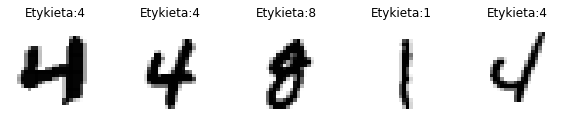

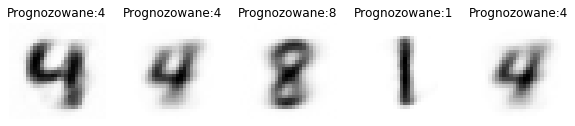

In [73]:
sample_images = sample_images.reshape(-1, 28, 28)
reconstructions = decoder_output_value.reshape([-1, 28, 28])

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.imshow(sample_images[index], cmap="binary")
    plt.title("Etykieta:" + str(mnist.test.labels[index]))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    plt.title("Prognozowane:" + str(y_pred_value[index]))
    plt.imshow(reconstructions[index], cmap="binary")
    plt.axis("off")
    
plt.show()


Wszystkie prognozy są właściwe, a rekonstrukcje wyglądają rewelacyjnie. Hurra!

# Interpretacja wektorów wyjściowych

Zmodyfikujmy wektore wyjściowe tak, aby sprawdzić, co oznaczają ich parametry. 

Najpierw sprawdźmy wymiary tablicy NumPy `cap2_output_value`:

In [74]:
caps2_output_value.shape

(5, 1, 10, 16, 1)

Stwórzmy funkcję, która będzie modyfikowała wszystkie 16 parametrów (wymiarów) we wszystkich wektorach wyjściowych. Każdy zmodyfikowany wektor będzie różnił się od jego pierwotnej wersji tym, że jeden z jego parametrów zostanie zmodyfikowany o jakąś wartość w przedziale od -0,5 do 0,5. Domyślnie będzie 11 etapów (-0,5, -0,4, ..., +0,4, +0,5). Funkcja ta zwróci tablicę o wymiarach (_zmodyfikowane parametry_=16, _kroki_=11, _rozmiar grupy_=5, 1, 10, 16, 1):

In [0]:
def tweak_pose_parameters(output_vectors, min=-0.5, max=0.5, n_steps=11):
    steps = np.linspace(min, max, n_steps) # -0,25, -0,15, ..., +0,25
    pose_parameters = np.arange(caps2_n_dims) # 0, 1, ..., 15
    tweaks = np.zeros([caps2_n_dims, n_steps, 1, 1, 1, caps2_n_dims, 1])
    tweaks[pose_parameters, :, 0, 0, 0, pose_parameters, 0] = steps
    output_vectors_expanded = output_vectors[np.newaxis, np.newaxis]
    return tweaks + output_vectors_expanded

Obliczmy wszystkie zmodyfikowane wektory wyjściowe i przekształćmy wynik do postaci (_parametry_×_kroki_×_przykłady_, 1, 10, 16, 1), dzięki czemu będziemy mogli przekazać tablicę do dekodera:

In [0]:
n_steps = 11

tweaked_vectors = tweak_pose_parameters(caps2_output_value, n_steps=n_steps)
tweaked_vectors_reshaped = tweaked_vectors.reshape(
    [-1, 1, caps2_n_caps, caps2_n_dims, 1])

Wprowadźmy tak zmodyfikowane wektory wyjściowe do dekodera i uzyskajmy rekonstrukcje: 

In [77]:
tweak_labels = np.tile(mnist.test.labels[:n_samples], caps2_n_dims * n_steps)

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    decoder_output_value = sess.run(
            decoder_output,
            feed_dict={caps2_output: tweaked_vectors_reshaped,
                       mask_with_labels: True,
                       y: tweak_labels})

INFO:tensorflow:Restoring parameters from ./moja_siec_kapsulowa


Przekształćmy wynik dekodera tak, abyśmy mogli z łatwością iterować po wymiarze wyjściowym, etapach modyfikacji i przykładach:

In [0]:
tweak_reconstructions = decoder_output_value.reshape(
        [caps2_n_dims, n_steps, n_samples, 28, 28])

Na koniec stwórzmy wykres wszystkich rekonstrukcji dla trzech pierwszych wymiarów wyjściowych, dla każdego etapu modyfikacji (kolumny) i dla każdej cyfry (rzędy):

Modyfikowanie wymiaru wyjściowego numer 0


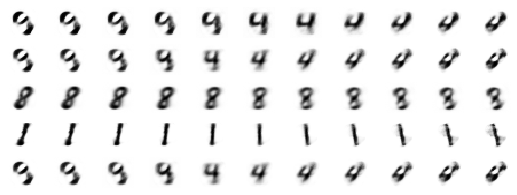

Modyfikowanie wymiaru wyjściowego numer 1


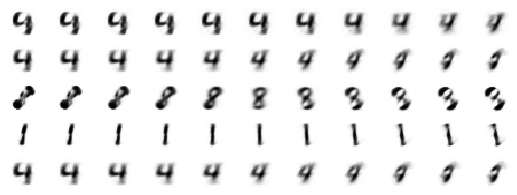

Modyfikowanie wymiaru wyjściowego numer 2


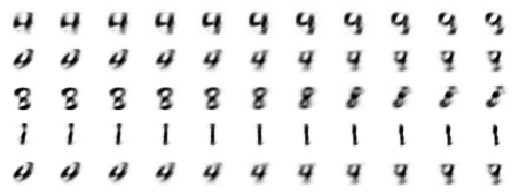

In [79]:
for dim in range(3):
    print("Modyfikowanie wymiaru wyjściowego numer {}".format(dim))
    plt.figure(figsize=(n_steps / 1.2, n_samples / 1.5))
    for row in range(n_samples):
        for col in range(n_steps):
            plt.subplot(n_samples, n_steps, row * n_steps + col + 1)
            plt.imshow(tweak_reconstructions[dim, col, row], cmap="binary")
            plt.axis("off")
    plt.show()

# Podsumowanie

Starałem się, aby zawarty w tym notatniku kod był możliwie prosty i zwięzły, dzięki czemu łatwiej byłoby analizować, ale, oczywiście, w praktyce chcesz umieścić go w przydatnych funkcjach i klasach wielokrotnego użytku. Mógłbyś, na przykład, spróbować zaimplementować własne klasy `PrimaryCapsuleLayer` czy `DenseRoutingCapsuleLayer`, zawierające parametry definiujące liczbę kapsuł, liczbę iteracji trasowania, mechanizm pętli statycznych lub dynamicznych itd. Jeżeli interesuje Cię implementacja modułowa sieci kapsułowych bazująca na module TensorFlow, sprawdź projekt [CapsNet-TensorFlow](https://github.com/naturomics/CapsNet-Tensorflow).

To wszystko na dzisiaj, mam nadzieję, że podobał Ci się ten notatnik!